## Calculate and plot the percentage of missing metrics for each California census tract
* Process all Cal-CRAI metrics and merge into one dataframe
* Calculate total percentage of missing (nan) data for each metric
* Bin the percentages
* Plot


In [1]:
import pandas as pd
import os
import sys
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import shutil
from osgeo import ogr
from collections import OrderedDict

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, delete_items
from scripts.utils.cal_crai_calculations import process_domain_csv_files
from scripts.utils.cal_crai_plotting import missing_metrics_plot

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  # Show full column width

## Pull all data from AWS index data bucket

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


## Isolate for metric files only, then run the processing function to merge into a single file

In [4]:
# when domain prefix is left, the function processes all metrics together
domain_prefix = ''
input_folder = r'aws_csvs'
output_folder = "all_metrics_folder"
meta_csv = r'../utils/calcrai_metrics.csv'

merged_output_file = f'concatenate_{domain_prefix}metrics.csv'
metric_vulnerable_resilient_dict = process_domain_csv_files(domain_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 110 CSV files within the '' domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 67
Replacing infinite entries (if any) with NaN.
Processed CSV saved as concatenate_metrics.csv


In [5]:
cal_crai_metrics_merged = pd.read_csv('concatenate_metrics.csv')
cal_crai_metrics_merged.head()

,GEOID,low_internet_download_flag,cellular_towers_data_count,percent_underground_transmission_lines,percent_housing_before_1980,percent_mobile_homes,percent_without_kitchen_facilities_or_plumbing,estimated_total_vacant_housing_units,microwave_towers_data_count,mobile_towers_data_count,paging_towers_data_count,power_plant_count,avg_num_psps_event,radio_towers_data_count,number_of_airports,number_of_bottlenecks,numbers_of_bridges,highway_length_in_miles,railway_length_in_miles,tv_contour_data_count,num_exclusive_wastewater_facilities,drought_coverage_percentage,drought_crop_loss_acres,drought_crop_loss_indemnity_amount,change_in_drought_years,percent_weeks_drought,mean_change_annual_heat_days,mean_change_annual_warm_nights,floodplain_percentage,avg_flood_insurance_payout_per_claim,estimated_flood_crop_loss_cost,precip_99percentile,surface_runoff,total_flood_fatalities,median_flood_warning_days,mean_change_cold_days,heat_crop_loss_acres,heat_crop_loss_indemnity_amount,avg_age_adjust_heat_hospitalizations_per_10000,median_heat_warning_days,slr_vulnerable_building_content_cost,fire_stations_count_diff,hospitals_count_diff,police_stations_count_diff,schools_count_diff,building_exposed_slr_count,slr_vulnerability_delta_percentage_change,slr_vulnerable_wastewater_treatment_count,rcp_4.5__50th_percent_change,burn_area_m2,change_ffwi_days,average_damaged_destroyed_structures_wildfire,average_annual_fatalities_wildfire,median_red_flag_warning_days,nfip_participation,total_emergency_management_funding,num_emergency_medical_technicians_and_paramedics_employed_per_10000,num_firefighting_and_prevention_workers_employed_per_10000,num_fire_stations_per_10000_people,num_flood_policies,total_hazard_mitigation_funding,housing_units_with_mortgage,percent_prepared_for_general_disaster,percent_prepared_without_power,percent_prepared_without_water,num_police_officers_employed_per_10000,num_registered_nurses_employed_per_10000,percent_under_timber_management,percent_sampled_wells_contaminated,percent_unhealthy_air_quality,protected_areas_percentage,esi_mean,ssma_mean,percent_vulnerable_soils,percent_vulnerable_drought,percent_vulnerable_fire,SpBioWtEco,tract_percent_impervious,percent_population_ambulatory_disabilities,percent_total_pop_american_indian_alaska_native,blood and organ banks per 10000 people,percent_population_cognitive_disabilities,est_gini_index,hachman_index,est_median_income_dollars,percent_children_household_financial_assistance,percent_1miurban_10mirural,health and personal care stores per 10000 people,heavy and civil engineering construction per 10000 people,hospitals per 10000 people,avg_hpsscore_mental_shortage_metric,narcotic_support_per_10000,real_percent_total_pop_over_65,personal and household goods repair and maintenance per 10000 people,avg_hpsscore_primary_care_metric,specialty trade contractors per 10000 people,percent_total_pop_under_5,asthma_related_ed_visits_per_10000_people_2019,cardiovascular_disease_related_ed_visits_per_10000_people_2019,education_percent_2019,avg_percent_population_homeless,housing_burden_percent_2019,sum_imp_water_bodies,linguistic_isolation_percent_2019,low_birth_weight_percent_2019,Percent of households without air conditioning,Percent of population employed and aged > 16 working outdoors,poverty_percent_2019,unemployment_percent_2019,"Number of Violent Crimes per 10,000 Population",percent_population_without_health_insurance
0,6001400100,0.0,2.0,0.0,15.032680,2.0,0.0,119.0,734.0,28.0,12.0,0.0,0.8,19.0,3.0,5.0,302.0,920.83816,181.100468,13.0,16.0,37.98437,197.583333,7394.25,3.50,0.570255,2.683333,17.908333,NaN,5463.8925,0.0,0.817024,1.264492,1.0,3.0,-3.225,769.522222,14348.571429,74.25,2.0,650084.0,3.0,0.0,1.0,14.0,1315.0,NaN,4.0,-3.740648,NaN,0.0,4.0,0.0,3.5,1.0,3835219.0,6.220614,6.461024,0.552943,2642.0,1.935016e+08,68.7,52.380952,57.142857,57.142857,12.441227,82.13013,NaN,NaN,3.664105,17.313634,-0.153958,-0.150978,85.7,94.2,86.1,0.788310,10.386114,4.680330,0.0,0.042072,5.170005,0.4228,0.926

## Function to calculate percent missing metrics

In [6]:
def calculate_missing_percentage_and_columns(df, geoid_column='GEOID'):
    """
    Calculates the percentage of missing entries/metrics and lists missing column names for each GEOID in the given DataFrame.
    
    Parameters:
    ----------
    df : pd.DataFrame
        The DataFrame containing the GEOID and other columns.
    geoid_column : str
        The name of the column representing GEOIDs.
    
    Returns:
    -------
    pd.DataFrame
        A new DataFrame with GEOID, the percentage of missing entries, and a list of missing columns for each GEOID.
    """
    # Ensure the GEOID column exists in the DataFrame
    if geoid_column not in df.columns:
        raise ValueError(f"Column '{geoid_column}' not found in the DataFrame.")
    
    # Group by GEOID to handle duplicates
    grouped = df.groupby(geoid_column)

    # Calculate the percentage of missing values for each GEOID
    missing_percentage = grouped.apply(lambda g: g.isnull().mean(axis=1).mean() * 100)

    # Identify missing columns for each GEOID
    missing_columns = grouped.apply(lambda g: g.columns[g.isnull().any()].tolist())

    # Create a new DataFrame with GEOID, missing percentage, and missing columns
    result_df = pd.DataFrame({
        geoid_column: missing_percentage.index,
        'missing_percentage': missing_percentage.values,
        'missing_columns': missing_columns.values
    })
    
    return result_df

In [7]:
missing_metric = calculate_missing_percentage_and_columns(cal_crai_metrics_merged)

C:\Users\jesse\AppData\Local\Temp\ipykernel_21256\2675591568.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_percentage = grouped.apply(lambda g: g.isnull().mean(axis=1).mean() * 100)
C:\Users\jesse\AppData\Local\Temp\ipykernel_21256\2675591568.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_columns = grouped.apply(lambda g: g.columns[g.isnull().any()].tolist())


## Inspect the missing metric column

In [8]:
# Calculate IQR
q1 = missing_metric['missing_percentage'].quantile(0.25)  # First quartile (25th percentile)
q3 = missing_metric['missing_percentage'].quantile(0.75)  # Third quartile (75th percentile)
iqr = q3 - q1

# Print IQR
print("IQR:", iqr)

# Max value in the column
max_value = missing_metric['missing_percentage'].max()
print("Max Value:", max_value)

IQR: 5.405405405405405
Max Value: 99.09909909909909


## Only 8 census tracts have missing metrics above 30%
* 7 of which are less than 40%
* The last one is the island off the San Francisco area which we set to nan when calculating the index

In [9]:
large_values = missing_metric['missing_percentage'] > 30
large_value_rows = missing_metric[large_values]
print(len(large_value_rows))
large_value_rows.head()

8


,GEOID,missing_percentage,missing_columns
379,6003010000,30.630631,"[mobile_towers_data_count, paging_towers_data_count, radio_towers_data_count, number_of_bottlenecks, railway_length_in_miles, drought_crop_loss_acres, drought_crop_loss_indemnity_amount, heat_crop_loss_acres, heat_crop_loss_indemnity_amount, avg_age_adjust_heat_hospitalizations_per_10000, slr_vulnerable_building_content_cost, fire_stations_count_diff, hospitals_count_diff, police_stations_count_diff, schools_count_diff, building_exposed_slr_count, slr_vulnerability_delta_percentage_change, slr_vulnerable_wastewater_treatment_count, rcp_4.5__50th_percent_change, housing_units_with_mortgage, percent_under_timber_management, percent_vulnerable_soils, percent_vulnerable_drought, percent_vulnerable_fire, blood and organ banks per 10000 people, health and personal care stores per 10000 people, heavy and civil engineering construction per 10000 people, hospitals per 10000 people, avg_hpsscore_mental_shortage_metric, narcotic_support_per_10000, personal and household goods repair and maintenance per 10000 people, avg_hpsscore_primary_care_metric, specialty trade contractors per 10000 people, low_birth_weight_percent_2019]"
710,6015000107,31.531532,"[mobile_towers_data_count, number_of_bottlenecks, railway_length_in_miles, drought_crop_loss_acres, drought_crop_loss_indemnity_amount, avg_flood_insurance_payout_per_claim, heat_crop_loss_acres, heat_crop_loss_indemnity_amount, avg_age_adjust_heat_hospitalizations_per_10000, median_heat_warning_days, slr_vulnerable_building_content_cost, building_exposed_slr_count, slr_vulnerability_delta_percentage_change, slr_vulnerable_wastewater_treatment_count, burn_area_m2, housing_units_with_mortgage, percent_prepared_for_general_disaster, percent_prepared_without_power, percent_prepared_without_water, percent_sampled_wells_contaminated, ssma_mean, percent_vulnerable_soils, percent_vulnerable_drought, percent_vulnerable_fire, blood and organ banks per 10000 people, health and personal care stores per 10000 people, heavy and civil engineering construction per 10000 people, avg_hpsscore_mental_shortage_metric, narcotic_support_per_10000, personal and household goods repair and maintenance per 10000 people, avg_hpsscore_primary_care_metric, asthma_related_ed_visits_per_10000_people_2019, cardiovascular_disease_related_ed_visits_per_10000_people_2019, low_birth_weight_percent_2019, Percent of households without air conditioning]"
714,6015990000,37.837838,"[percent_housing_before_1980, percent_without_kitchen_facilities_or_plumbing, mobile_towers_data_count, number_of_bottlenecks, railway_length_in_miles, drought_crop_loss_acres, drought_crop_loss_indemnity_amount, avg_flood_insurance_payout_per_claim, heat_crop_loss_acres, heat_crop_loss_indemnity_amount, avg_age_adjust_heat_hospitalizations_per_10000, median_heat_warning_days, slr_vulnerable_building_content_cost, building_exposed_slr_count, slr_vulnerability_delta_percentage_change, slr_vulnerable_wastewater_treatment_count, housing_units_with_mortgage, percent_prepared_for_general_disaster, percent_prepared_without_power, percent_prepared_without_water, percent_sampled_wells_contaminated, protected_areas_percentage, ssma_mean, percent_vulnerable_soils, percent_vulnerable_drought, percent_vulnerable_fire, SpBioWtEco, percent_population_ambulatory_disabilities, blood and organ banks per 10000 people, percent_children_household_financial_assistance, health and personal care stores per 10000 people, heavy and civil engineering construction per 10000 people, avg_hpsscore_mental_shortage_metric, narcotic_support_per_10000, real_percent_total_pop_over_65, personal and household goods repair and maintenance per 10000 people, avg_hpsscore_primary_care_metric, asthma_related_ed_visits_per_10000_people_2019, cardiovascular_disease_related_ed_visits_per_10000_people_2019, low_birth_weight_percent_2019, Percent of households without air conditioning, percent_population_without_health_insurance]"


## Bin the data into 5 categorys based on inspected missing data column
* 0-5%
* 5-10%
* 10-20%
* 20-30%
* above 30%

In [10]:
# Binning based on actual column values
binned_missing_metric_df = missing_metric.copy()

# Define the columns to bin and the bin edges based on actual values
columns_to_bin = ['missing_percentage']
bin_edges = [0, 5, 10, 20, 30, 100]  # Define bin edges based on actual values

# Apply pd.cut to each specified column and print the bin edges
for column in columns_to_bin:
    binned_missing_metric_df[column + '_bin'], bin_edges = pd.cut(
        binned_missing_metric_df[column], 
        bins=bin_edges,  # Use actual values for binning
        right=False,  # Specify if the bins are inclusive on the right
        labels=['0-5', '5-10', '10-20', '20-30', '30+'],  # Custom labels for binning
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')
    
# Create a copy and chain the .replace() calls
binned_missing_metric_viz = binned_missing_metric_df.copy()
binned_missing_metric_viz['missing_percentage_bin'] = (
    binned_missing_metric_viz['missing_percentage_bin']
    .replace('0-5', '0-5%')
    .replace('5-10', '5-10%')
    .replace('10-20', '10-20%')
    .replace('20-30', '20-30%')
    .replace('30+', '30+%')
)

# Show the resulting DataFrame with the binned columns
binned_missing_metric_viz.head()

Bin edges for missing_percentage: [  0   5  10  20  30 100]


C:\Users\jesse\AppData\Local\Temp\ipykernel_21256\3385644091.py:22: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  binned_missing_metric_viz['missing_percentage_bin']


,GEOID,missing_percentage,missing_columns,missing_percentage_bin
0,6001400100,6.306306,"[floodplain_percentage, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric]",5-10%
1,6001400200,8.108108,"[floodplain_percentage, avg_flood_insurance_payout_per_claim, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, protected_areas_percentage, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric]",5-10%
2,6001400300,6.306306,"[floodplain_percentage, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric]",5-10%
3,6001400400,7.207207,"[floodplain_percentage, avg_flood_insurance_payout_per_claim, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric]",5-10%
4,6001400500,6.306306,"[floodplain_percentage, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric]",5-10%


## Further process the data so it plays nicely with plotting function
* adjust GEOID string length and datatype

In [11]:
# GEOID handling
binned_missing_metric_viz['GEOID'] = binned_missing_metric_viz['GEOID'].apply(lambda x: '0' + str(x))
binned_missing_metric_viz['GEOID'] = binned_missing_metric_viz['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

# Ensure all values in GEOID are strings
binned_missing_metric_viz['GEOID'] = binned_missing_metric_viz['GEOID'].astype(str)

# Display the dataframe
binned_missing_metric_viz.head()

,GEOID,missing_percentage,missing_columns,missing_percentage_bin
0,06001400100,6.306306,"[floodplain_percentage, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric]",5-10%
1,06001400200,8.108108,"[floodplain_percentage, avg_flood_insurance_payout_per_claim, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, protected_areas_percentage, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric]",5-10%
2,06001400300,6.306306,"[floodplain_percentage, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric]",5-10%
3,06001400400,7.207207,"[floodplain_percentage, avg_flood_insurance_payout_per_claim, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric]",5-10%
4,06001400500,6.306306,"[floodplain_percentage, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric]",5-10%


## Plot the missing metric columns

### Plot the missing percentage data as a coninuous scale, with the scale being adjustable

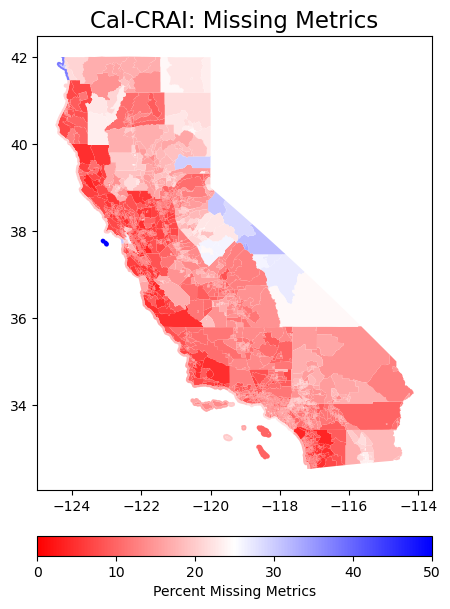

In [12]:
missing_metrics_plot(binned_missing_metric_viz, 
                     column='missing_percentage',
                     vmin=0, vmax=50,
                     plot_type='continuous', 
                     plot_title=True,
                     title='Cal-CRAI: Missing Metrics')

## Plot the binned missing metric data outlined prior

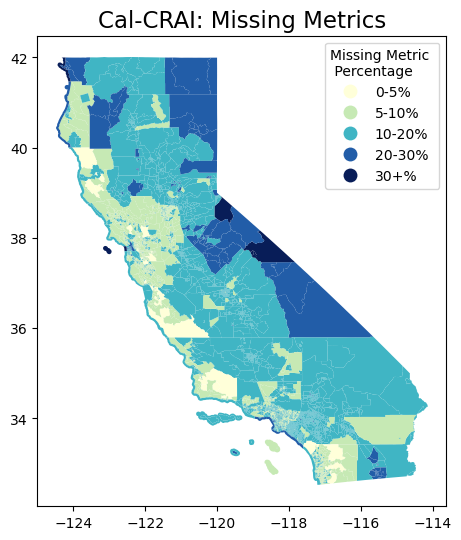

In [13]:
missing_metrics_plot(binned_missing_metric_viz,
                     'missing_percentage_bin',
                     save_name=f'Cal_CRAI_missing_metrics',
                     plot_title=True,
                     title='Cal-CRAI: Missing Metrics')

## Delete desired folders, figs, and files

In [14]:
folders_to_delete = ['aws_csvs', 'all_metrics_folder']
csv_files_to_delete = ["concatenate_metrics.csv"]
png_files_to_delete = ["Cal_CRAI_missing_metrics.png"]
#zip_to_delete = ['.zip']
#gdb_to_delete = ['.gdb']

delete_items(folders_to_delete, csv_files_to_delete, png_files=png_files_to_delete) #, gdb_folders=gdb_to_delete, zip_files=zip_to_delete)

Deleted folder: aws_csvs
Deleted folder: all_metrics_folder
Deleted file: concatenate_metrics.csv
Deleted PNG file: Cal_CRAI_missing_metrics.png
